In [12]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import cv2

%matplotlib inline

In [5]:
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C,[n_C, n_H*n_W])
    a_G_unrolled = tf.reshape(a_G,[n_C, n_H*n_W])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = 1/(4*n_H*n_W*n_C)*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))
    ### END CODE HERE ###
    
    return J_content

In [6]:
# GRADED FUNCTION: gram_matrix

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    ### START CODE HERE ### (≈1 line)
    GA = tf.matmul(A,tf.transpose(A))
    ### END CODE HERE ###
    
    return GA

In [7]:
# GRADED FUNCTION: compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.reshape(tf.transpose(a_S),[n_C, n_H*n_W])
    a_G = tf.reshape(tf.transpose(a_G),[n_C, n_H*n_W])

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = 1/((2*n_H*n_W*n_C)**2)*tf.reduce_sum(tf.square(tf.subtract(GS,GG)))
    
    ### END CODE HERE ###
    
    return J_style_layer

In [8]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [9]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [10]:
# GRADED FUNCTION: total_cost

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    ### START CODE HERE ### (≈1 line)
    J = alpha*J_content + beta*J_style
    ### END CODE HERE ###
    
    return J

In [11]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


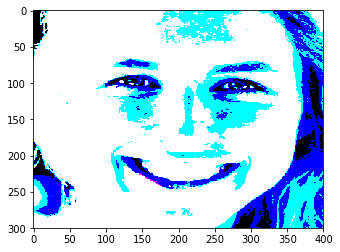

In [23]:
content_image = cv2.imread('headshot_kiahhardcastle_cropped.jpg') # load the image
content_image = cv2.resize(content_image, dsize=(400, 300), interpolation=cv2.INTER_CUBIC) #resize to correct dim
content_image = reshape_and_normalize_image(content_image)
imshow(content_image[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


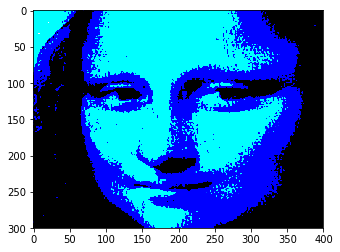

In [22]:
style_image = cv2.imread('mona_lisa_cropped.jpg') # load the image
style_image = cv2.resize(style_image, dsize=(400, 300), interpolation=cv2.INTER_CUBIC) #resize to correct dim
style_image = reshape_and_normalize_image(style_image)
imshow(style_image[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


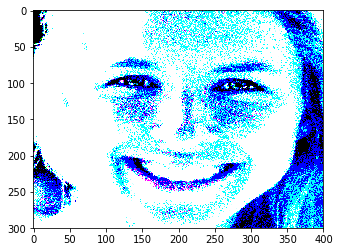

In [21]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [24]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

In [25]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [26]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [27]:
### START CODE HERE ### (1 line)
J = total_cost(J_content, J_style, alpha = 10, beta = 40)
### END CODE HERE ###

In [28]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [32]:
def model_nn(sess, input_image, num_iterations = 2000):
    
    # Initialize global variables (you need to run the session on the initializer)
    ### START CODE HERE ### (1 line)
    init = tf.global_variables_initializer() 
    ### END CODE HERE ###
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    ### START CODE HERE ### (1 line)
    sess.run(init)
    sess.run(model['input'].assign(input_image))
    ### END CODE HERE ###
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        ### START CODE HERE ### (1 line)
        sess.run(train_step)
        ### END CODE HERE ###
        
        # Compute the generated image by running the session on the current model['input']
        ### START CODE HERE ### (1 line)
        generated_image = sess.run(model['input'])
        ### END CODE HERE ###

        # Print every 20 iteration.
        if i%100 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            cv2.imwrite("output/" + str(i) + ".jpg", generated_image)
    
    # save last generated image
    cv2.imwrite("output/" + str(i) + ".jpg", generated_image)
    
    return generated_image

In [31]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 23409725000.0
content cost = 9892.436
style cost = 585240700.0
Iteration 20 :
total cost = 5567572500.0
content cost = 19997.625
style cost = 139184300.0
Iteration 40 :
total cost = 2368579800.0
content cost = 21228.115
style cost = 59209190.0
Iteration 60 :
total cost = 1403664400.0
content cost = 21583.541
style cost = 35086216.0
Iteration 80 :
total cost = 999726660.0
content cost = 21843.543
style cost = 24987706.0
Iteration 100 :
total cost = 777828100.0
content cost = 22035.004
style cost = 19440194.0
Iteration 120 :
total cost = 633096960.0
content cost = 22201.068
style cost = 15821873.0
Iteration 140 :
total cost = 529731970.0
content cost = 22332.695
style cost = 13237716.0
Iteration 160 :
total cost = 451226800.0
content cost = 22450.682
style cost = 11275058.0
Iteration 180 :
total cost = 389146370.0
content cost = 22558.021
style cost = 9723020.0


array([[[[  52.944355 ,  165.09688  ,   87.98167  ],
         [   8.753252 ,    0.7617694,    2.6266463],
         [ -78.0333   ,  -71.307465 ,  -13.833711 ],
         ...,
         [  78.52445  ,   74.65047  ,   85.92829  ],
         [  80.98463  ,   73.81738  ,  102.17097  ],
         [ 136.70212  ,  112.30269  ,   78.49913  ]],

        [[  21.724838 ,  177.77736  ,    4.210849 ],
         [-157.46693  ,  -71.95199  ,  -50.91211  ],
         [-134.79065  ,  -73.84892  ,  -26.26745  ],
         ...,
         [  56.960262 ,   74.608536 ,   95.40434  ],
         [  56.316837 ,   69.98003  ,   91.27277  ],
         [  75.27716  ,   73.54785  ,  111.46618  ]],

        [[  -4.1314883,  116.15772  ,   33.216606 ],
         [-132.27547  ,  -59.809    ,  -34.400173 ],
         [ -91.518745 ,  -63.444115 ,  -15.034323 ],
         ...,
         [  43.103027 ,   68.07811  ,  103.83687  ],
         [  57.849667 ,   61.782402 ,   98.682884 ],
         [  56.11828  ,   67.011505 ,  121.24606  ]],